In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from warnings import filterwarnings

filterwarnings("ignore")

## 1 - Prepare data

In [3]:
import pandas as pd

def convert_column_to_numeric(df, column_name):
    """
    Convertit une colonne contenant des chaînes numériques avec virgules
    en valeurs numériques Python (float).
    """
    if column_name in df.columns:
        # Remplacer les virgules par des points
        df[column_name] = df[column_name].astype(str).str.replace(',', '.', regex=False)
        # Convertir en type numérique
        df[column_name] = pd.to_numeric(df[column_name], errors="coerce")
        print(f"Colonne convertie : '{column_name}'")
    return df

def clean_and_convert_dataframe(df):
    """
    Nettoie et convertit les colonnes pertinentes du DataFrame :
    - Supprime les colonnes inutiles
    - Supprime les espaces autour des noms de colonnes
    - Convertit certaines colonnes en type numérique
    - Supprime les doublons
    - Supprime les lignes avec Hardness > 1500
    """
    # 🔹 Étape 1 : Nettoyage des noms de colonnes
    df.columns = df.columns.str.strip()

    # 🔹 Étape 2 : Suppression des colonnes inutiles si elles existent
    columns_to_drop = [
        'Citation',
        'Citation Link',
        'Protein',
        'Unnamed: 21'
    ]
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
    print("Colonnes supprimées si présentes :", columns_to_drop)

    # 🔹 Étape 3 : Colonnes à convertir en numérique
    columns_to_convert = [
        'Hardness/firmness/strength (g)',
        'Protein Concentration (%)',
        'Additives',
        'If a gel can be formed (0-1)',
        'Additives Concentration (%)',
        'ionic strength (M)',
        'pH',
        'Treatment condition value'
    ]
    for col in columns_to_convert:
        df = convert_column_to_numeric(df, col)

    # 🔹 Étape 4 : Supprimer les doublons
    df.drop_duplicates(inplace=True)
    print("Doublons supprimés.")


    return df


In [4]:
# ========================
# 🧪 Exemple d'utilisation
# ========================

csv_path = r"C:\Users\harri\ai_bobby_repository\data\raw\Hardness.csv"
df = pd.read_csv(csv_path, sep=";")
df_cleaned = clean_and_convert_dataframe(df)

# Aperçu du résultat
print("Aperçu du DataFrame nettoyé :")
df_cleaned.head()

Colonnes supprimées si présentes : ['Citation', 'Citation Link', 'Protein', 'Unnamed: 21']
Colonne convertie : 'Hardness/firmness/strength (g)'
Colonne convertie : 'Protein Concentration (%)'
Colonne convertie : 'Additives'
Colonne convertie : 'If a gel can be formed (0-1)'
Colonne convertie : 'Additives Concentration (%)'
Colonne convertie : 'ionic strength (M)'
Colonne convertie : 'pH'
Colonne convertie : 'Treatment condition value'
Doublons supprimés.
Aperçu du DataFrame nettoyé :


,Protein codes,Protein Concentration (%),Treatment code,Treatment condition code,Treatment condition value,Treatment temperature ( °C),Treatment time (min),Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Storage time (h),If a gel can be formed (0-1),Hardness/firmness/strength (g)
0,10501,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,90.0,30.0,4.0,12.0,1,131.91
1,10501,12.0,NaN,NaN,NaN,NaN,NaN,80203.0,0.5,5.0,NaN,NaN,90.0,30.0,4.0,12.0,1,155.91
2,10501,12.0,NaN,NaN,NaN,NaN,NaN,80203.0,1.0,5.0,NaN,NaN,90.0,30.0,4.0,12.0,1,151.14
3,10501,12.0,NaN,NaN,NaN,NaN,NaN,80203.0,2.0,5.0,NaN,NaN,90.0,30.0,4.0,12.0,1,144.84
4,10501,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,90.0,30.0,4.0,12.0,1,95.71


In [449]:
df_cleaned['pH'].value_counts()

pH
7.00     397
6.50      72
6.00      47
9.00      32
8.00      32
        ... 
8.34       1
6.84       1
8.88       1
6.87       1
11.08      1
Name: count, Length: 71, dtype: int64

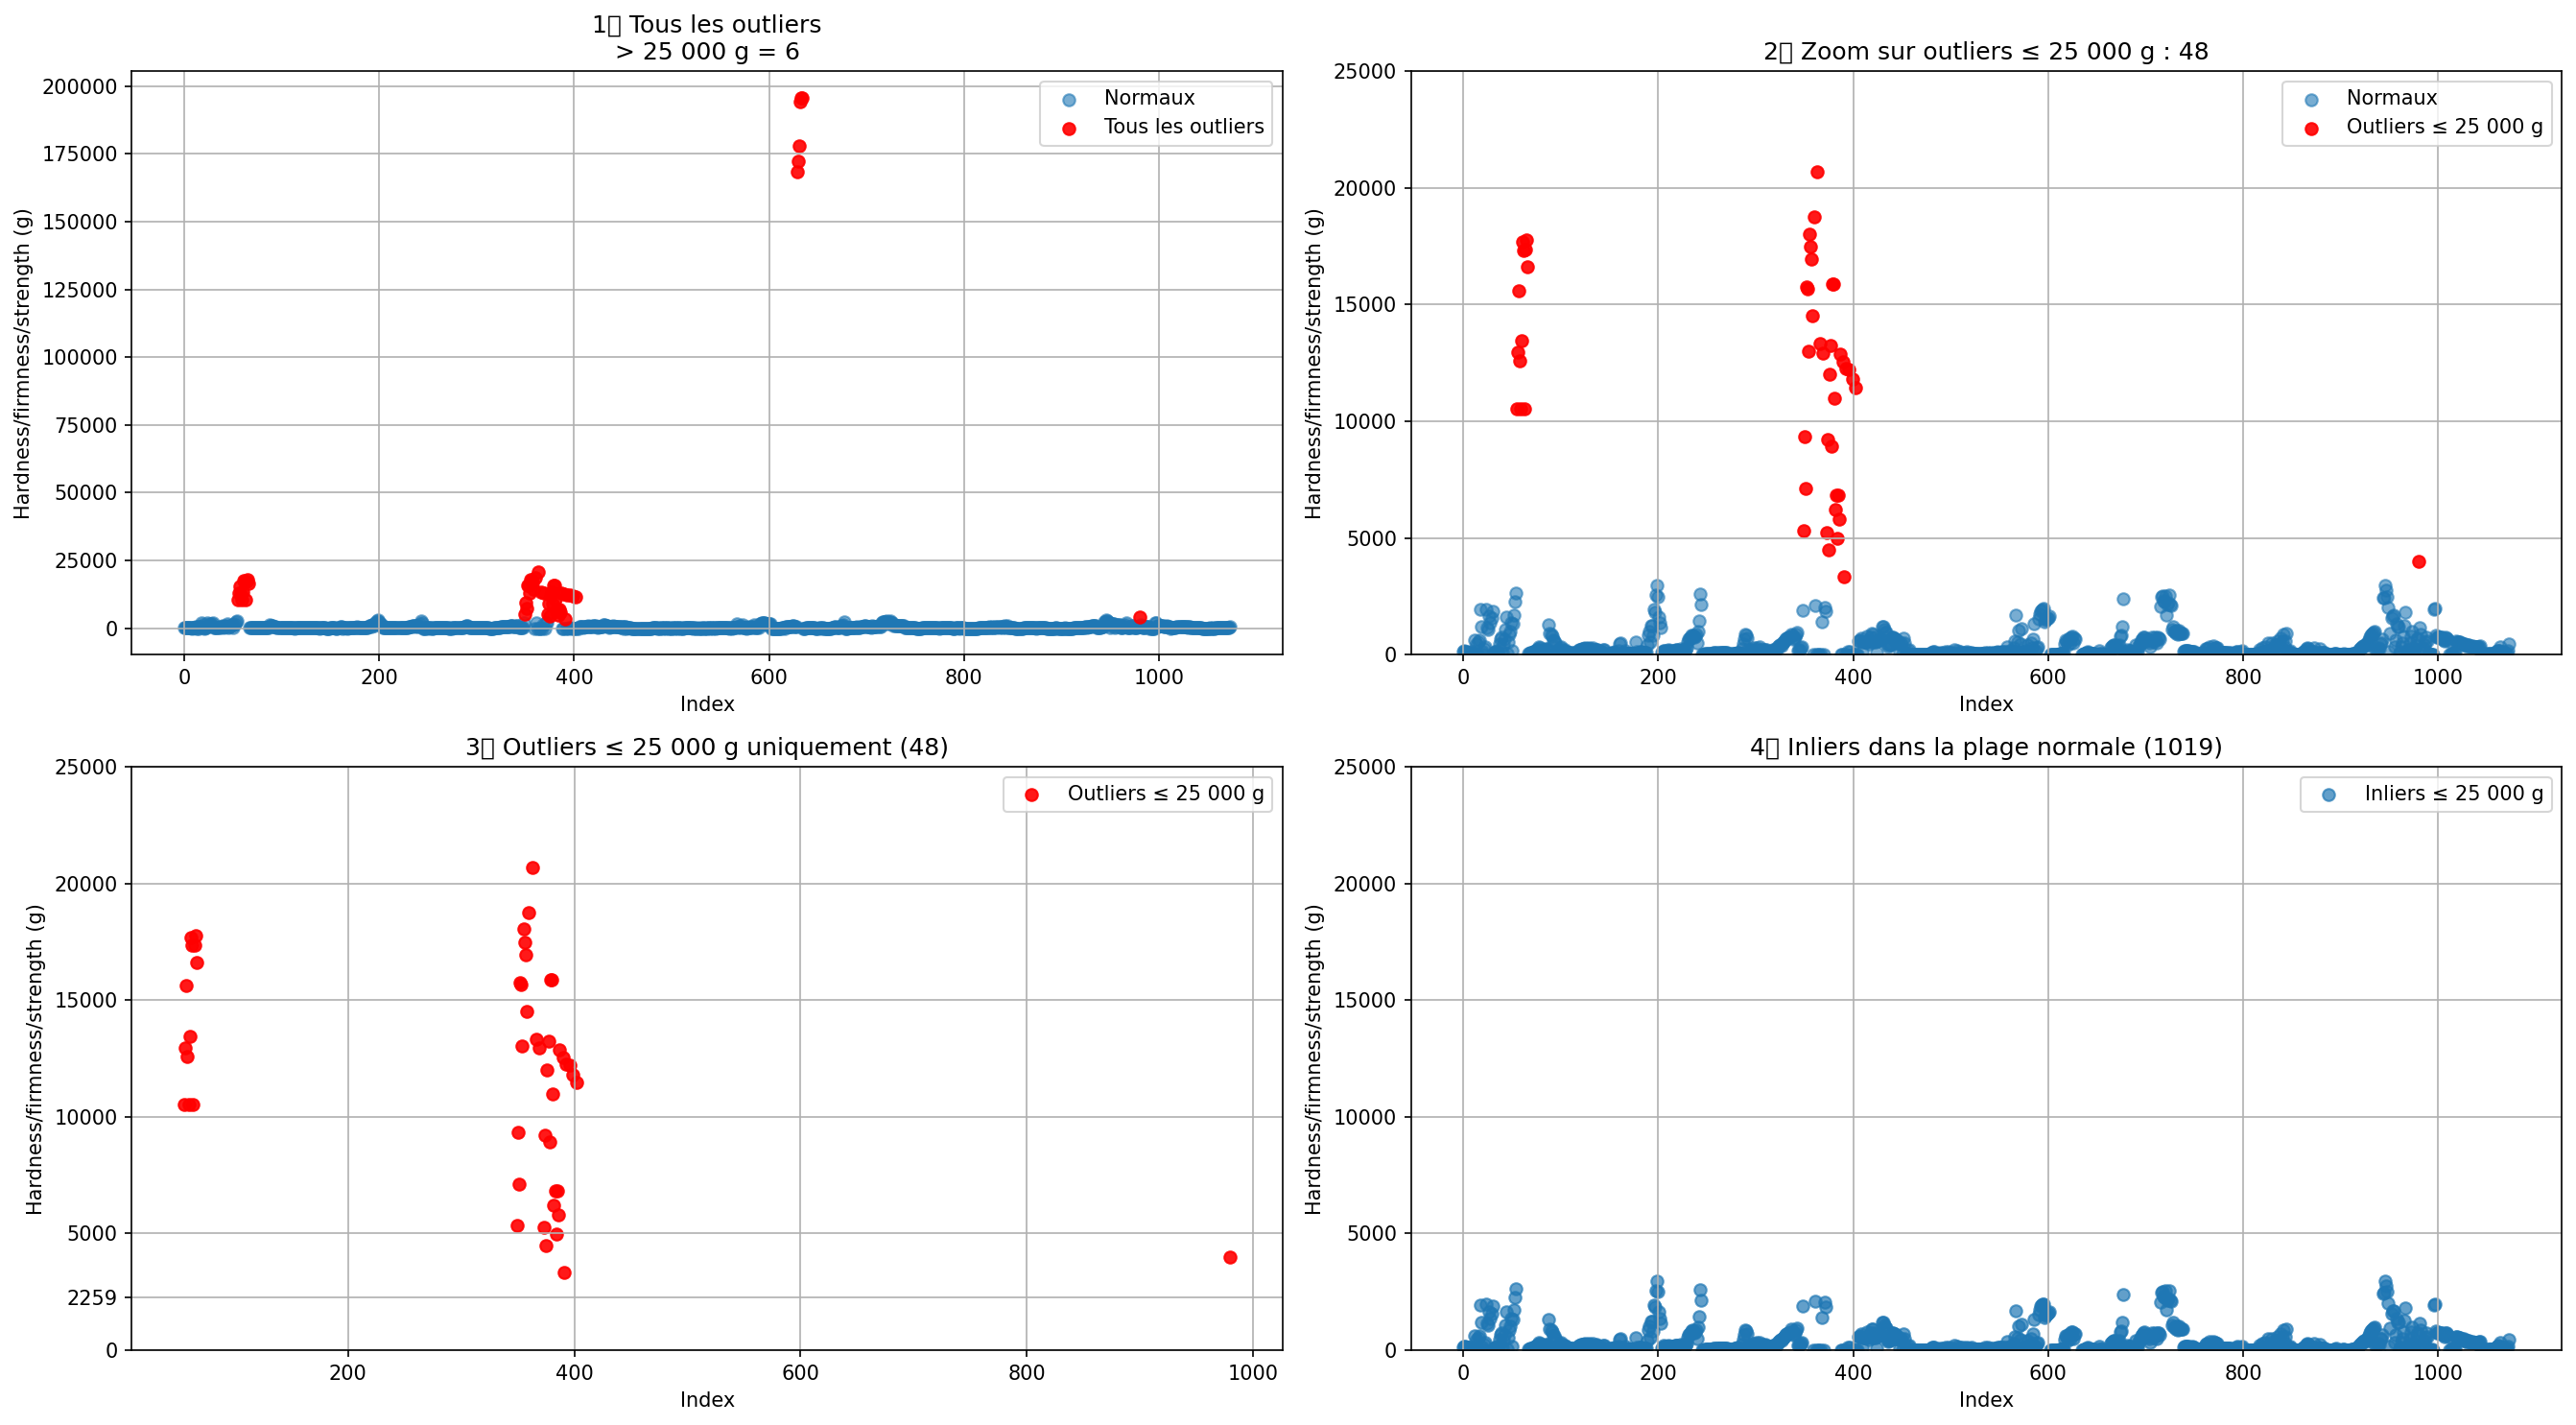

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Détection des outliers avec IsolationForest
iso = IsolationForest(contamination=0.05, random_state=42)
df_cleaned['outlier'] = iso.fit_predict(df_cleaned[['Hardness/firmness/strength (g)']])

# 2. Séparation des groupes
outliers = df_cleaned[df_cleaned['outlier'] == -1]
inliers = df_cleaned[df_cleaned['outlier'] != -1]

outliers_gt_25000 = outliers[outliers['Hardness/firmness/strength (g)'] > 25000]
outliers_leq_25000 = outliers[outliers['Hardness/firmness/strength (g)'] <= 25000]
inliers_leq_25000 = inliers[inliers['Hardness/firmness/strength (g)'] <= 25000]

# 3. Création du subplot 2x2
fig, axes = plt.subplots(2, 2, figsize=(18, 10), dpi=150)

# --- [0, 0] Tous les inliers + tous les outliers
axes[0, 0].scatter(inliers.index,
                   inliers['Hardness/firmness/strength (g)'],
                   label='Normaux', alpha=0.6)
axes[0, 0].scatter(outliers.index,
                   outliers['Hardness/firmness/strength (g)'],
                   color='red', label='Tous les outliers', alpha=0.9)
axes[0, 0].set_title(f"1️⃣ Tous les outliers\n> 25 000 g = {len(outliers_gt_25000)}")
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("Hardness/firmness/strength (g)")
axes[0, 0].legend()
axes[0, 0].grid(True)

# --- [0, 1] Tous les inliers + seulement outliers ≤ 25 000
axes[0, 1].scatter(inliers.index,
                   inliers['Hardness/firmness/strength (g)'],
                   label='Normaux', alpha=0.6)
axes[0, 1].scatter(outliers_leq_25000.index,
                   outliers_leq_25000['Hardness/firmness/strength (g)'],
                   color='red', label='Outliers ≤ 25 000 g', alpha=0.9)
axes[0, 1].set_ylim(0, 25000)
axes[0, 1].set_title(f"2️⃣ Zoom sur outliers ≤ 25 000 g : {len(outliers_leq_25000)}")
axes[0, 1].set_xlabel("Index")
axes[0, 1].set_ylabel("Hardness/firmness/strength (g)")
axes[0, 1].legend()
axes[0, 1].grid(True)


# --- [1, 0] Outliers ≤ 25 000 g uniquement avec marge et valeur de début affichée
y_values = outliers_leq_25000['Hardness/firmness/strength (g)']
y_min = y_values.min()
marge = 0.05 * (25000 - y_min)  # 5% de marge visuelle
y_axis_min = y_min - marge

axes[1, 0].scatter(outliers_leq_25000.index,
                   y_values,
                   color='red', label='Outliers ≤ 25 000 g', alpha=0.9)

axes[1, 0].set_ylim(y_axis_min, 25000)
axes[1, 0].set_title(f"3️⃣ Outliers ≤ 25 000 g uniquement ({len(outliers_leq_25000)})")
axes[1, 0].set_xlabel("Index")
axes[1, 0].set_ylabel("Hardness/firmness/strength (g)")
axes[1, 0].legend()
axes[1, 0].grid(True)

# 🔢 Ajoute explicitement la graduation du bas avec sa valeur
yticks = axes[1, 0].get_yticks().tolist()
if y_axis_min not in yticks:
    yticks.insert(0, round(y_axis_min))  # ou round(y_axis_min, 1) si tu veux plus de précision
axes[1, 0].set_yticks(yticks)





# --- [1, 1] Seulement inliers dans plage normale (≤ 25 000)
axes[1, 1].scatter(inliers_leq_25000.index,
                   inliers_leq_25000['Hardness/firmness/strength (g)'],
                   label='Inliers ≤ 25 000 g', alpha=0.7)
axes[1, 1].set_ylim(0, 25000)
axes[1, 1].set_title(f"4️⃣ Inliers dans la plage normale ({len(inliers_leq_25000)})")
axes[1, 1].set_xlabel("Index")
axes[1, 1].set_ylabel("Hardness/firmness/strength (g)")
axes[1, 1].legend()
axes[1, 1].grid(True)

# Affichage propre
plt.tight_layout()
plt.show()


In [6]:
# Création du DataFrame sans outliers, basé sur les données du graphe 4
df_no_outliers = inliers[inliers['Hardness/firmness/strength (g)'] <= 25000].copy()

# Suppression de la colonne 'outlier'
df_no_outliers.drop(columns='outlier', inplace=True)

# Affichage de la taille
print("Shape du DataFrame sans outliers (graphe 4, colonne supprimée) :", df_no_outliers.shape)

# Aperçu
display(df_no_outliers.head())


Shape du DataFrame sans outliers (graphe 4, colonne supprimée) : (1019, 18)


,Protein codes,Protein Concentration (%),Treatment code,Treatment condition code,Treatment condition value,Treatment temperature ( °C),Treatment time (min),Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Storage time (h),If a gel can be formed (0-1),Hardness/firmness/strength (g)
0,10501,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,90.0,30.0,4.0,12.0,1,131.91
1,10501,12.0,NaN,NaN,NaN,NaN,NaN,80203.0,0.5,5.0,NaN,NaN,90.0,30.0,4.0,12.0,1,155.91
2,10501,12.0,NaN,NaN,NaN,NaN,NaN,80203.0,1.0,5.0,NaN,NaN,90.0,30.0,4.0,12.0,1,151.14
3,10501,12.0,NaN,NaN,NaN,NaN,NaN,80203.0,2.0,5.0,NaN,NaN,90.0,30.0,4.0,12.0,1,144.84
4,10501,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,90.0,30.0,4.0,12.0,1,95.71


## Replace outliers data

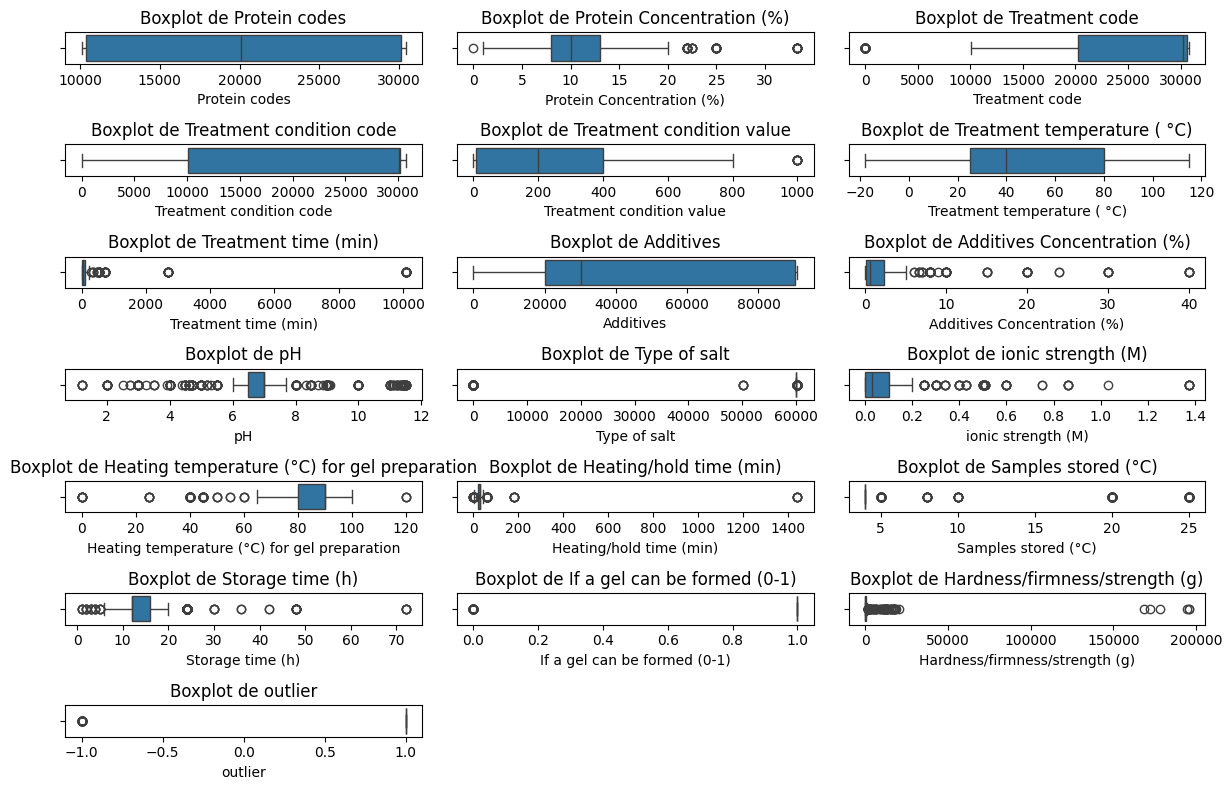

In [ ]:
'''import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(df):
    """
    Affiche des boxplots pour toutes les colonnes numériques du DataFrame.
    
    Args:
    - df : DataFrame contenant les données à analyser.
    """
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Initialiser la figure
    plt.figure(figsize=(12, 8))
    
    # Créer un boxplot pour chaque colonne numérique
    for i, col in enumerate(numeric_cols):
        plt.subplot(len(numeric_cols)//3 + 1, 3, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
    
    plt.tight_layout()  # Ajuster l'espacement entre les subplots
    plt.show()

# Exemple d'utilisation :
plot_boxplots(df_cleaned)'''


In [ ]:
'''import numpy as np

def replace_outliers_with_mean(df):
    """
    Remplace les outliers dans chaque colonne numérique par la moyenne de cette colonne,
    sauf pour la colonne pH.
    Un outlier est défini comme une valeur en dehors de [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR].
    
    Args:
    - df : DataFrame contenant les données à analyser.
    
    Returns:
    - DataFrame avec les outliers remplacés par la moyenne.
    """
    # Sélectionner uniquement les colonnes numériques sauf pH
    numeric_cols = df.select_dtypes(include=['number']).columns
    numeric_cols = [col for col in numeric_cols if col != 'pH']  # Exclure la colonne pH
    
    for col in numeric_cols:
        # Calculer les quartiles Q1 et Q3, ainsi que l'IQR (écart interquartile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Définir les limites pour les outliers
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        # Remplacer les outliers par la moyenne de la colonne
        mean_value = df[col].mean()
        df[col] = df[col].apply(lambda x: mean_value if x < lower_limit or x > upper_limit else x)
        
    return df

# Exemple d'utilisation :
df = replace_outliers_with_mean(df_cleaned)'''


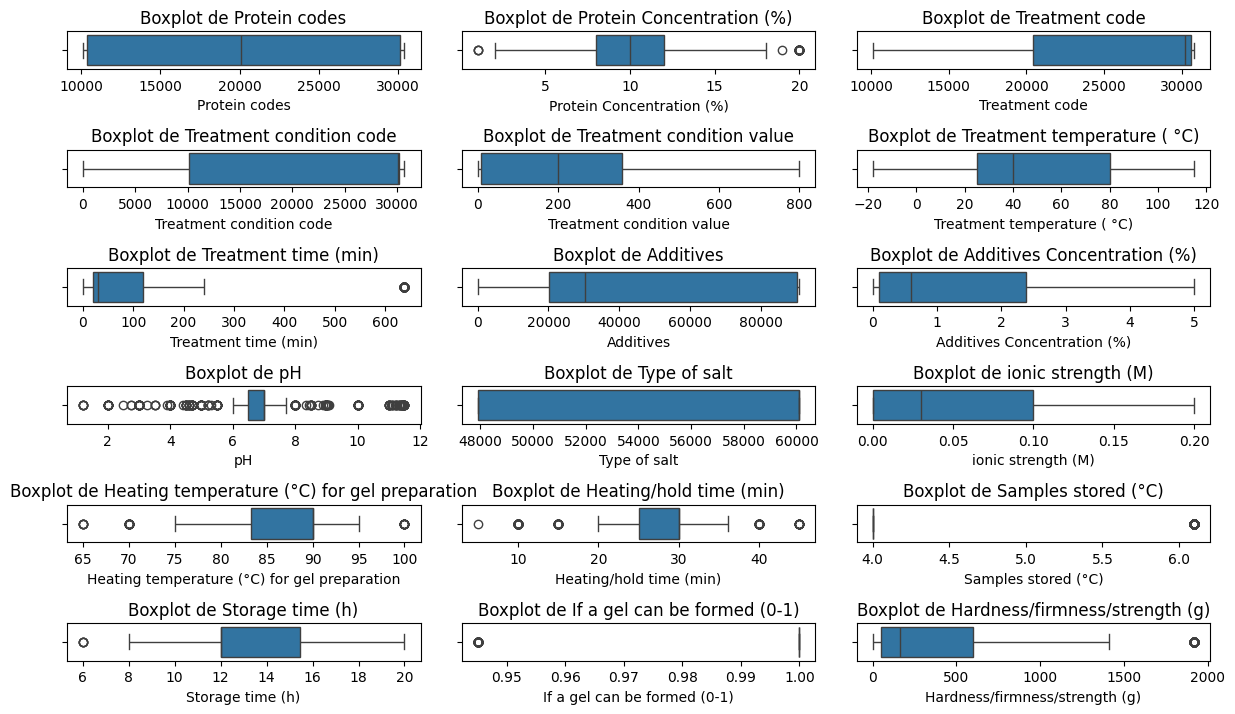

In [ ]:
'''import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(df):
    """
    Affiche des boxplots pour toutes les colonnes numériques du DataFrame.
    
    Args:
    - df : DataFrame contenant les données à analyser.
    """
    # Sélectionner uniquement les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Initialiser la figure
    plt.figure(figsize=(12, 8))
    
    # Créer un boxplot pour chaque colonne numérique
    for i, col in enumerate(numeric_cols):
        plt.subplot(len(numeric_cols)//3 + 1, 3, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot de {col}')
    
    plt.tight_layout()  # Ajuster l'espacement entre les subplots
    plt.show()

# Exemple d'utilisation :
plot_boxplots(df)'''


In [7]:
df_no_outliers.isna().sum()

Protein codes                                     0
Protein Concentration (%)                         0
Treatment code                                  358
Treatment condition code                        744
Treatment condition value                       786
Treatment temperature ( °C)                     617
Treatment time (min)                            488
Additives                                       375
Additives Concentration (%)                     398
pH                                              201
Type of salt                                    502
ionic strength (M)                              502
Heating temperature (°C) for gel preparation    169
Heating/hold time (min)                         169
Samples stored (°C)                             105
Storage time (h)                                217
If a gel can be formed (0-1)                      0
Hardness/firmness/strength (g)                    0
dtype: int64

## Imputation with KNN

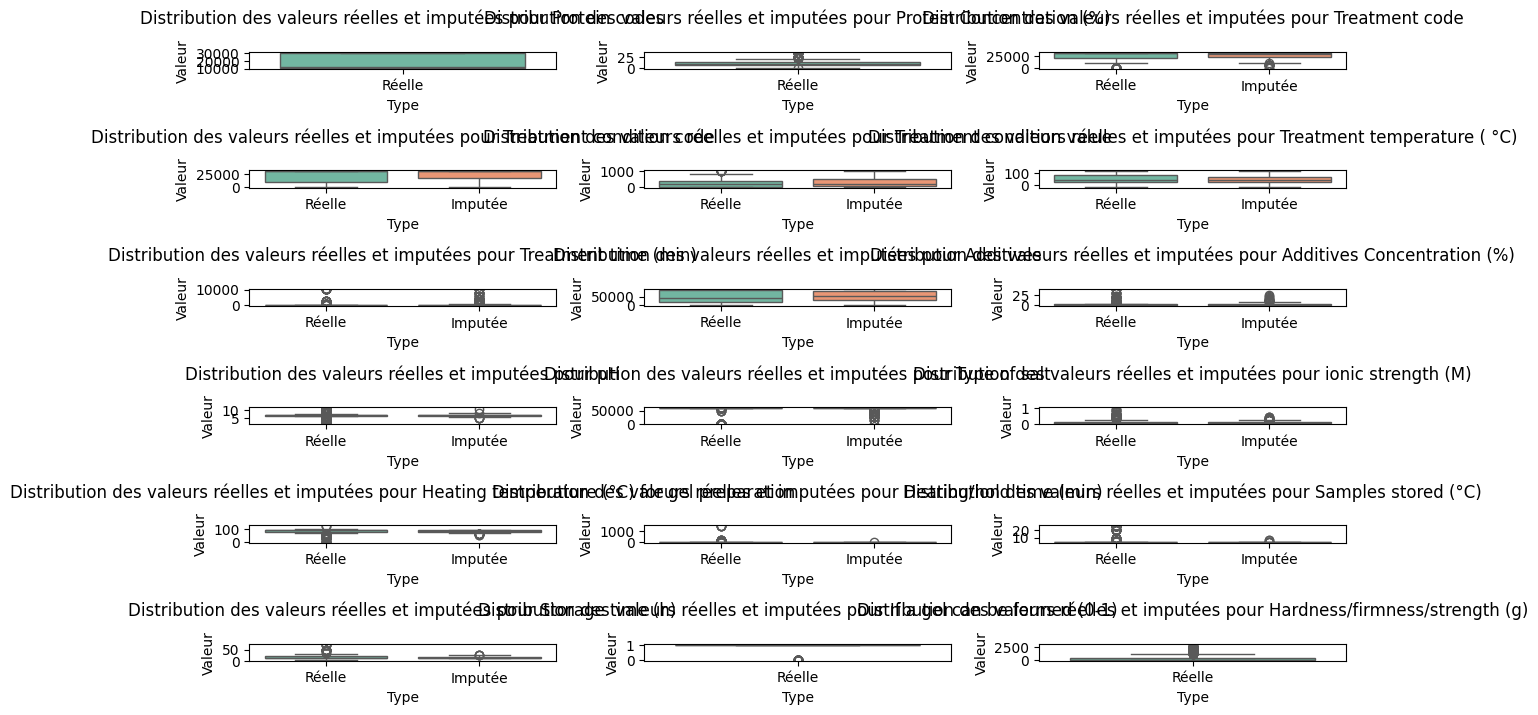

In [8]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

def knn_imputation_and_evaluation(df):
    """
    Effectue l'imputation KNN sur les colonnes numériques du DataFrame, puis compare
    les distributions des valeurs réelles et des valeurs imputées.
    
    Args:
    - df : DataFrame contenant les données à traiter.
    
    Retourne:
    - df_imputed : DataFrame avec les valeurs imputées.
    """
    # Sélectionner les colonnes numériques
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Créer un masque pour les valeurs manquantes
    nan_mask = df[numeric_cols].isna()
    
    # Appliquer l'imputation KNN
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = df.copy()
    
    # Appliquer l'imputation sur les colonnes numériques uniquement
    df_imputed[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    # Comparer les distributions des valeurs réelles et des valeurs imputées
    # Visualisation avec des boxplots pour chaque colonne
    fig = plt.figure(figsize=(12, 8))
    
    for i, col in enumerate(numeric_cols):
        ax = fig.add_subplot(len(numeric_cols)//3 + 1, 3, i + 1)
        
        # Réinitialiser les index pour éviter les duplications après concaténation
        real_values = df[col].dropna().reset_index(drop=True)
        imputed_values = df_imputed.loc[nan_mask[col], col].reset_index(drop=True)
        
        # Combiner les valeurs réelles et imputées pour chaque colonne
        data = pd.DataFrame({
            'Valeur': pd.concat([real_values, imputed_values], ignore_index=True),
            'Type': ['Réelle'] * len(real_values) + ['Imputée'] * len(imputed_values)
        })
        
        # Plot des valeurs réelles et imputées avec un "hue" pour différencier
        sns.boxplot(x='Type', y='Valeur', data=data, palette="Set2", ax=ax)
        
        ax.set_title(f'Distribution des valeurs réelles et imputées pour {col}', fontsize=12, pad=20)
    
    # Ajuster les marges autour de l'ensemble de la figure pour les titres
    plt.subplots_adjust(hspace=0.6, top=0.9)  # Espacement entre les sous-figures et ajustement de la marge en haut
    plt.tight_layout()
    plt.show()
    
    return df_imputed

# Exemple d'utilisation :
df_imputed = knn_imputation_and_evaluation(df_no_outliers)


In [ ]:
'''def save_missing_and_imputed(original_df, imputed_df):
    """
    Sauvegarde les lignes avec des valeurs manquantes et les lignes après imputation 
    dans deux fichiers Excel distincts.
    
    Args:
    - original_df : DataFrame avant imputation (avec valeurs manquantes).
    - imputed_df : DataFrame après imputation (valeurs imputées).
    """
    # Identifier les lignes avec des valeurs manquantes
    missing_rows = original_df[original_df.isna().any(axis=1)]
    
    # Sélectionner les mêmes lignes après imputation
    imputed_rows = imputed_df.loc[missing_rows.index]
    
    # Sauvegarder les deux DataFrames au format Excel
    missing_rows.to_excel("original_data_missingRow.xlsx", index=True)
    imputed_rows.to_excel("Imputation_data_ImputeRow.xlsx", index=True)
    
    print("✅ Les fichiers ont été sauvegardés :")
    print("- original_data_missingRow.xlsx (valeurs manquantes)")
    print("- Imputation_data_ImputeRow.xlsx (valeurs imputées)")
    
    return missing_rows, imputed_rows

# Exemple d'utilisation :
missing_rows, imputed_rows = save_missing_and_imputed(df, df_imputed)'''

✅ Les fichiers ont été sauvegardés :
- original_data_missingRow.xlsx (valeurs manquantes)
- Imputation_data_ImputeRow.xlsx (valeurs imputées)


In [9]:
df_imputed.isna().sum()

Protein codes                                   0
Protein Concentration (%)                       0
Treatment code                                  0
Treatment condition code                        0
Treatment condition value                       0
Treatment temperature ( °C)                     0
Treatment time (min)                            0
Additives                                       0
Additives Concentration (%)                     0
pH                                              0
Type of salt                                    0
ionic strength (M)                              0
Heating temperature (°C) for gel preparation    0
Heating/hold time (min)                         0
Samples stored (°C)                             0
Storage time (h)                                0
If a gel can be formed (0-1)                    0
Hardness/firmness/strength (g)                  0
dtype: int64

In [10]:
# Afficher les lignes dupliquées
duplicated_rows = df_imputed[df_imputed.duplicated()]

# Afficher le nombre de lignes dupliquées
print(f"Nombre de lignes dupliquées: {duplicated_rows.shape[0]}")

# Afficher les lignes dupliquées
duplicated_rows


Nombre de lignes dupliquées: 0


,Protein codes,Protein Concentration (%),Treatment code,Treatment condition code,Treatment condition value,Treatment temperature ( °C),Treatment time (min),Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Storage time (h),If a gel can be formed (0-1),Hardness/firmness/strength (g)


In [11]:
df_imputed.drop_duplicates(inplace=True)

## Univariate analysis on (Hardness/firmness/strength)

In [12]:
df_imputed["Hardness/firmness/strength (g)"].unique()

array([1.31910e+02, 1.55910e+02, 1.51140e+02, 1.44840e+02, 9.57100e+01,
       1.07430e+02, 1.09450e+02, 1.18660e+02, 2.94500e+01, 4.63400e+01,
       5.83800e+01, 9.76500e+01, 6.06480e+02, 0.00000e+00, 4.61780e+02,
       5.45950e+02, 6.22050e+02, 1.93095e+03, 1.20244e+03, 1.25950e+02,
       2.51820e+02, 3.19560e+02, 1.95782e+03, 1.17266e+03, 1.09108e+03,
       1.65191e+03, 1.35620e+03, 1.56014e+03, 1.87625e+03, 7.76000e+01,
       9.54400e+01, 1.42760e+02, 1.83550e+02, 6.00600e+01, 7.24000e+01,
       4.74160e+02, 6.81160e+02, 7.60700e+02, 1.11960e+02, 4.26230e+02,
       6.57710e+02, 1.08088e+03, 1.63050e+03, 5.14900e+01, 5.38400e+02,
       8.54510e+02, 1.01664e+03, 1.37558e+03, 1.69270e+02, 1.30929e+03,
       1.71412e+03, 2.26985e+03, 2.64408e+03, 5.30200e+01, 6.32200e+01,
       7.54600e+01, 7.95400e+01, 8.05600e+01, 9.78900e+01, 1.25420e+02,
       1.57030e+02, 1.19300e+02, 2.07000e+02, 2.59000e+02, 3.42620e+02,
       3.07950e+02, 1.27430e+02, 1.54570e+02, 1.35690e+02, 2.123

KeyError: "['outlier'] not in index"

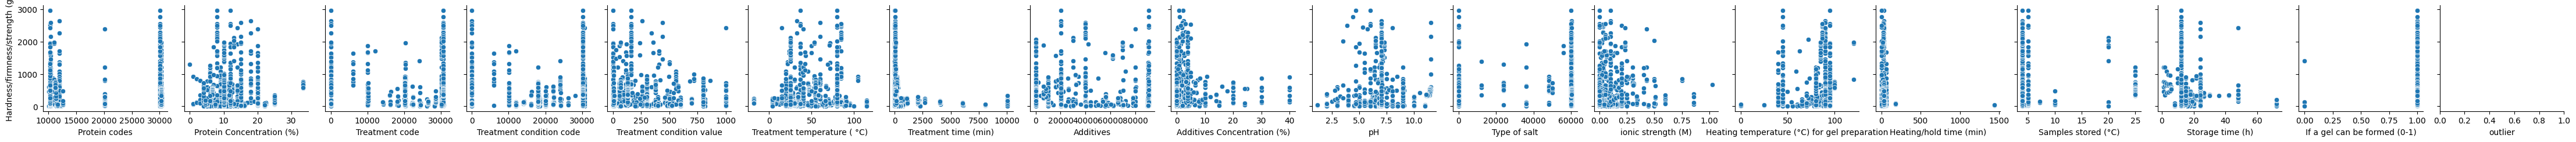

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définir la variable pour l'axe Y
y_var = "Hardness/firmness/strength (g)"  # Remplace par le nom de ta colonne cible

# Sélectionner toutes les autres colonnes sauf y_var pour l'axe X
x_vars = [col for col in df.columns if col != y_var]

# Créer le pairplot en mode horizontal
sns.pairplot(df_imputed, x_vars=x_vars, y_vars=[y_var], diag_kind="kde", height=2.5)

# Afficher le graphique
plt.show()


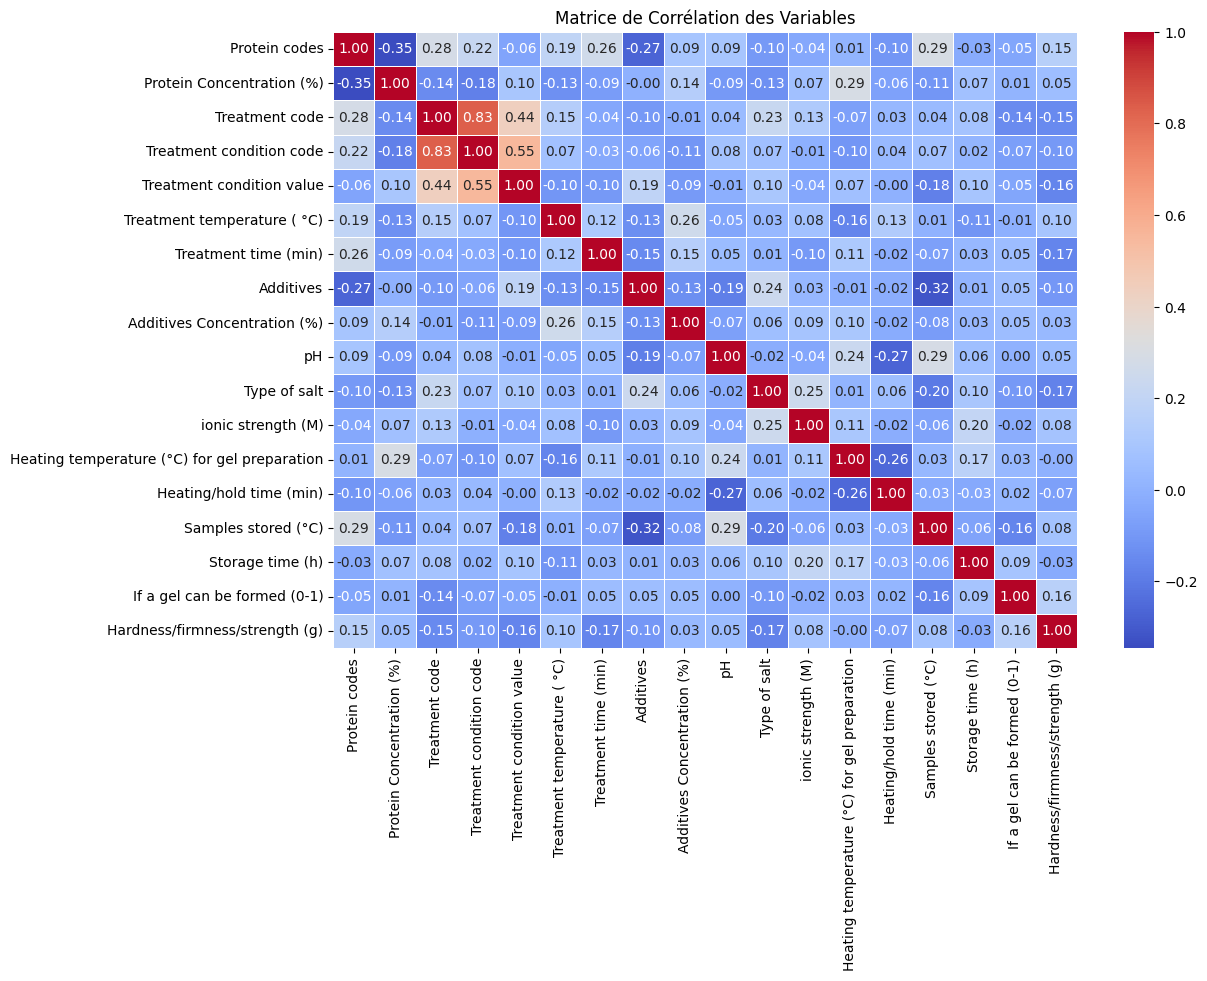

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définition de la figure
plt.figure(figsize=(12, 8))

# Heatmap avec annotations et une palette de couleurs contrastée
sns.heatmap(df_imputed.select_dtypes(include="number").corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Ajout d'un titre
plt.title("Matrice de Corrélation des Variables")

# Affichage du graphique
plt.show()

**Correlation of Pearson**

In [14]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(df_imputed["Hardness/firmness/strength (g)"], df_imputed["Samples stored (°C)"])
print(f"Corrélation de Pearson : {corr:.2f}, p-value : {p_value:.5f}")

Corrélation de Pearson : 0.08, p-value : 0.01516


<Axes: >

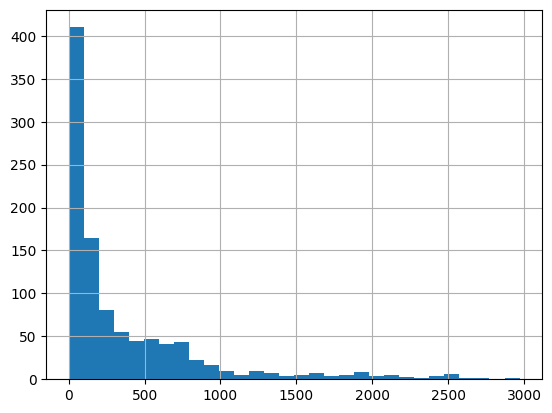

In [15]:
df_imputed["Hardness/firmness/strength (g)"].hist(bins=30)

## 2 - Train models

In [119]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer

# ----------------------------
# Étape 1 - Séparation X / y
# ----------------------------
X = df_imputed.drop('Hardness/firmness/strength (g)', axis=1)
y = df_imputed['Hardness/firmness/strength (g)']

# ----------------------------
# Étape 2 - Préparation Box-Cox (valeurs strictement positives)
# ----------------------------
if (y <= 0).any():
    offset = abs(y.min()) + 1
    y_shifted = y + offset
    print(f"⚠️ Valeurs ≤ 0 détectées — décalage appliqué : +{offset}")
else:
    y_shifted = y.copy()
    offset = 0

# ----------------------------
# Étape 3 - Transformation Box-Cox
# ----------------------------
pt = PowerTransformer(method='box-cox')
y_boxcox = pt.fit_transform(y_shifted.values.reshape(-1, 1)).flatten()

# Optionnel : convertir en Series avec même index que y d'origine
y_boxcox_series = pd.Series(y_boxcox, index=y.index)

# ----------------------------
# Affichage résumé
# ----------------------------
print("✅ Transformation Box-Cox appliquée à la cible.")
print("→ Shape :", y_boxcox_series.shape)
print("→ Aperçu :")
display(y_boxcox_series.head())


⚠️ Valeurs ≤ 0 détectées — décalage appliqué : +1.0
✅ Transformation Box-Cox appliquée à la cible.
→ Shape : (1019,)
→ Aperçu :


0   -0.11
1   -0.02
2   -0.03
3   -0.06
4   -0.30
dtype: float64

In [108]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PowerTransformer

# ----------------------------
# Étape 1 - Séparation X / y
# ----------------------------
X = df_imputed.drop('Hardness/firmness/strength (g)', axis=1)
y = df_imputed['Hardness/firmness/strength (g)']

# ----------------------------
# Étape 2 - Préparation Box-Cox (valeurs strictement positives)
# ----------------------------
if (y <= 0).any():
    offset = abs(y.min()) + 1
    y_shifted = y + offset
    print(f"⚠️ Valeurs ≤ 0 détectées — décalage appliqué : +{offset}")
else:
    y_shifted = y.copy()
    offset = 0

# ----------------------------
# Étape 3 - Transformation Box-Cox
# ----------------------------
pt = PowerTransformer(method='box-cox')
y_boxcox = pt.fit_transform(y_shifted.values.reshape(-1, 1)).flatten()
y_boxcox_series = pd.Series(y_boxcox, index=y.index)

# ----------------------------
# Étape 4 - Sélection des lignes où y > 200 (dans l'espace original)
mask_y_sup_200 = y > 200
X_sup_200 = X[mask_y_sup_200]
y_sup_200_boxcox = y_boxcox_series[mask_y_sup_200]

# ----------------------------
# Étape 5 - Fonction mixup ciblé
# ----------------------------
def mixup(X, y, alpha=0.3, n_mix=None):
    if n_mix is None:
        n_mix = len(X)
    X_mix, y_mix = [], []
    for _ in range(n_mix):
        i, j = np.random.randint(0, len(X), 2)
        lam = np.random.beta(alpha, alpha)
        x_new = lam * X.iloc[i] + (1 - lam) * X.iloc[j]
        y_new = lam * y.iloc[i] + (1 - lam) * y.iloc[j]
        X_mix.append(x_new)
        y_mix.append(y_new)
    return pd.DataFrame(X_mix, columns=X.columns), pd.Series(y_mix)

# ----------------------------
# Étape 6 - Mixup uniquement sur les y > 200
X_mix, y_mix = mixup(X_sup_200, y_sup_200_boxcox, alpha=0.3, n_mix=len(X_sup_200))

# ----------------------------
# Étape 7 - Fusion avec les données originales
X_augmented = pd.concat([X, X_mix], ignore_index=True)
y_augmented = pd.concat([y_boxcox_series, y_mix], ignore_index=True)

# ----------------------------
# Résumé
# ----------------------------
print(f"🔹 Données originales : {X.shape}")
print(f"🔹 Cas avec y > 200   : {X_sup_200.shape}")
print(f"➕ Données augmentées : {X_mix.shape}")
print(f"✅ Dataset final      : {X_augmented.shape}")


⚠️ Valeurs ≤ 0 détectées — décalage appliqué : +1.0
🔹 Données originales : (1019, 17)
🔹 Cas avec y > 200   : (441, 17)
➕ Données augmentées : (441, 17)
✅ Dataset final      : (1460, 17)


In [120]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb


# ----------------------------
# Séparation train/test
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_boxcox_series, test_size=0.2, random_state=42
)

# ----------------------------
# Initialisation des modèles
# ----------------------------
models = {
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "LinearSVR": LinearSVR(random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, random_state=42)
}


In [121]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 9. Entraînement et évaluation des modèles
results = []

# Boucle sur les modèles
for name, model in models.items():
    # Création d'un pipeline avec le modèle
    pipeline = Pipeline([("model", model)])
    
    # Entraînement
    pipeline.fit(X_train, y_train)
    
    # Prédictions
    y_pred = pipeline.predict(X_test)
    
    # Calcul des métriques
    metrics = {
        "R²": round(r2_score(y_test, y_pred) * 100, 2),  # Conversion en pourcentage et arrondi
        "MAE": round(mean_absolute_error(y_test, y_pred), 2),
        "MSE": round(mean_squared_error(y_test, y_pred), 2),
        "RMSE": round(mean_squared_error(y_test, y_pred, squared=False), 2)  # Ajout de la RMSE
    }
    
    # Stockage des résultats dans une liste
    results.append({"Modèle": name, **metrics})

# 10. Affichage des résultats sous forme de DataFrame
df_results = pd.DataFrame(results).sort_values(by="R²", ascending=False)

# Affichage du DataFrame sans notation scientifique
pd.set_option("display.float_format", "{:.2f}".format)

# Affichage des résultats
df_results


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 815, number of used features: 17
[LightGBM] [Info] Start training from score -0.004320
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

,Modèle,R²,MAE,MSE,RMSE
8,XGBoost,94.55,0.15,0.05,0.23
9,LightGBM,94.30,0.16,0.06,0.24
7,CatBoost,94.16,0.15,0.06,0.24
6,RandomForest,92.00,0.18,0.08,0.28
2,GradientBoosting,90.48,0.23,0.09,0.31
5,KNeighbors,76.13,0.31,0.24,0.49
3,AdaBoost,73.27,0.42,0.26,0.51
1,ElasticNet,29.54,0.64,0.69,0.83
4,LinearSVR,11.09,0.71,0.88,0.94
0,SGDRegressor,-75384399510377895187173889882955186176.00,752493413742798720.00,743510189361468375969354026833674240.00,862270369061507456.00


In [122]:
from catboost import CatBoostRegressor

# Initialisation du modèle
model = XGBRegressor(n_estimators=100, random_state=42)

# Entraînement du modèle avec les features ET la cible
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R² Score: 0.9546
Mean Absolute Error (MAE): 74.4666
Root Mean Squared Error (RMSE): 136.5962

R² Score: 0.9455
Mean Absolute Error (MAE): 0.1476
Root Mean Squared Error (RMSE): 0.2318


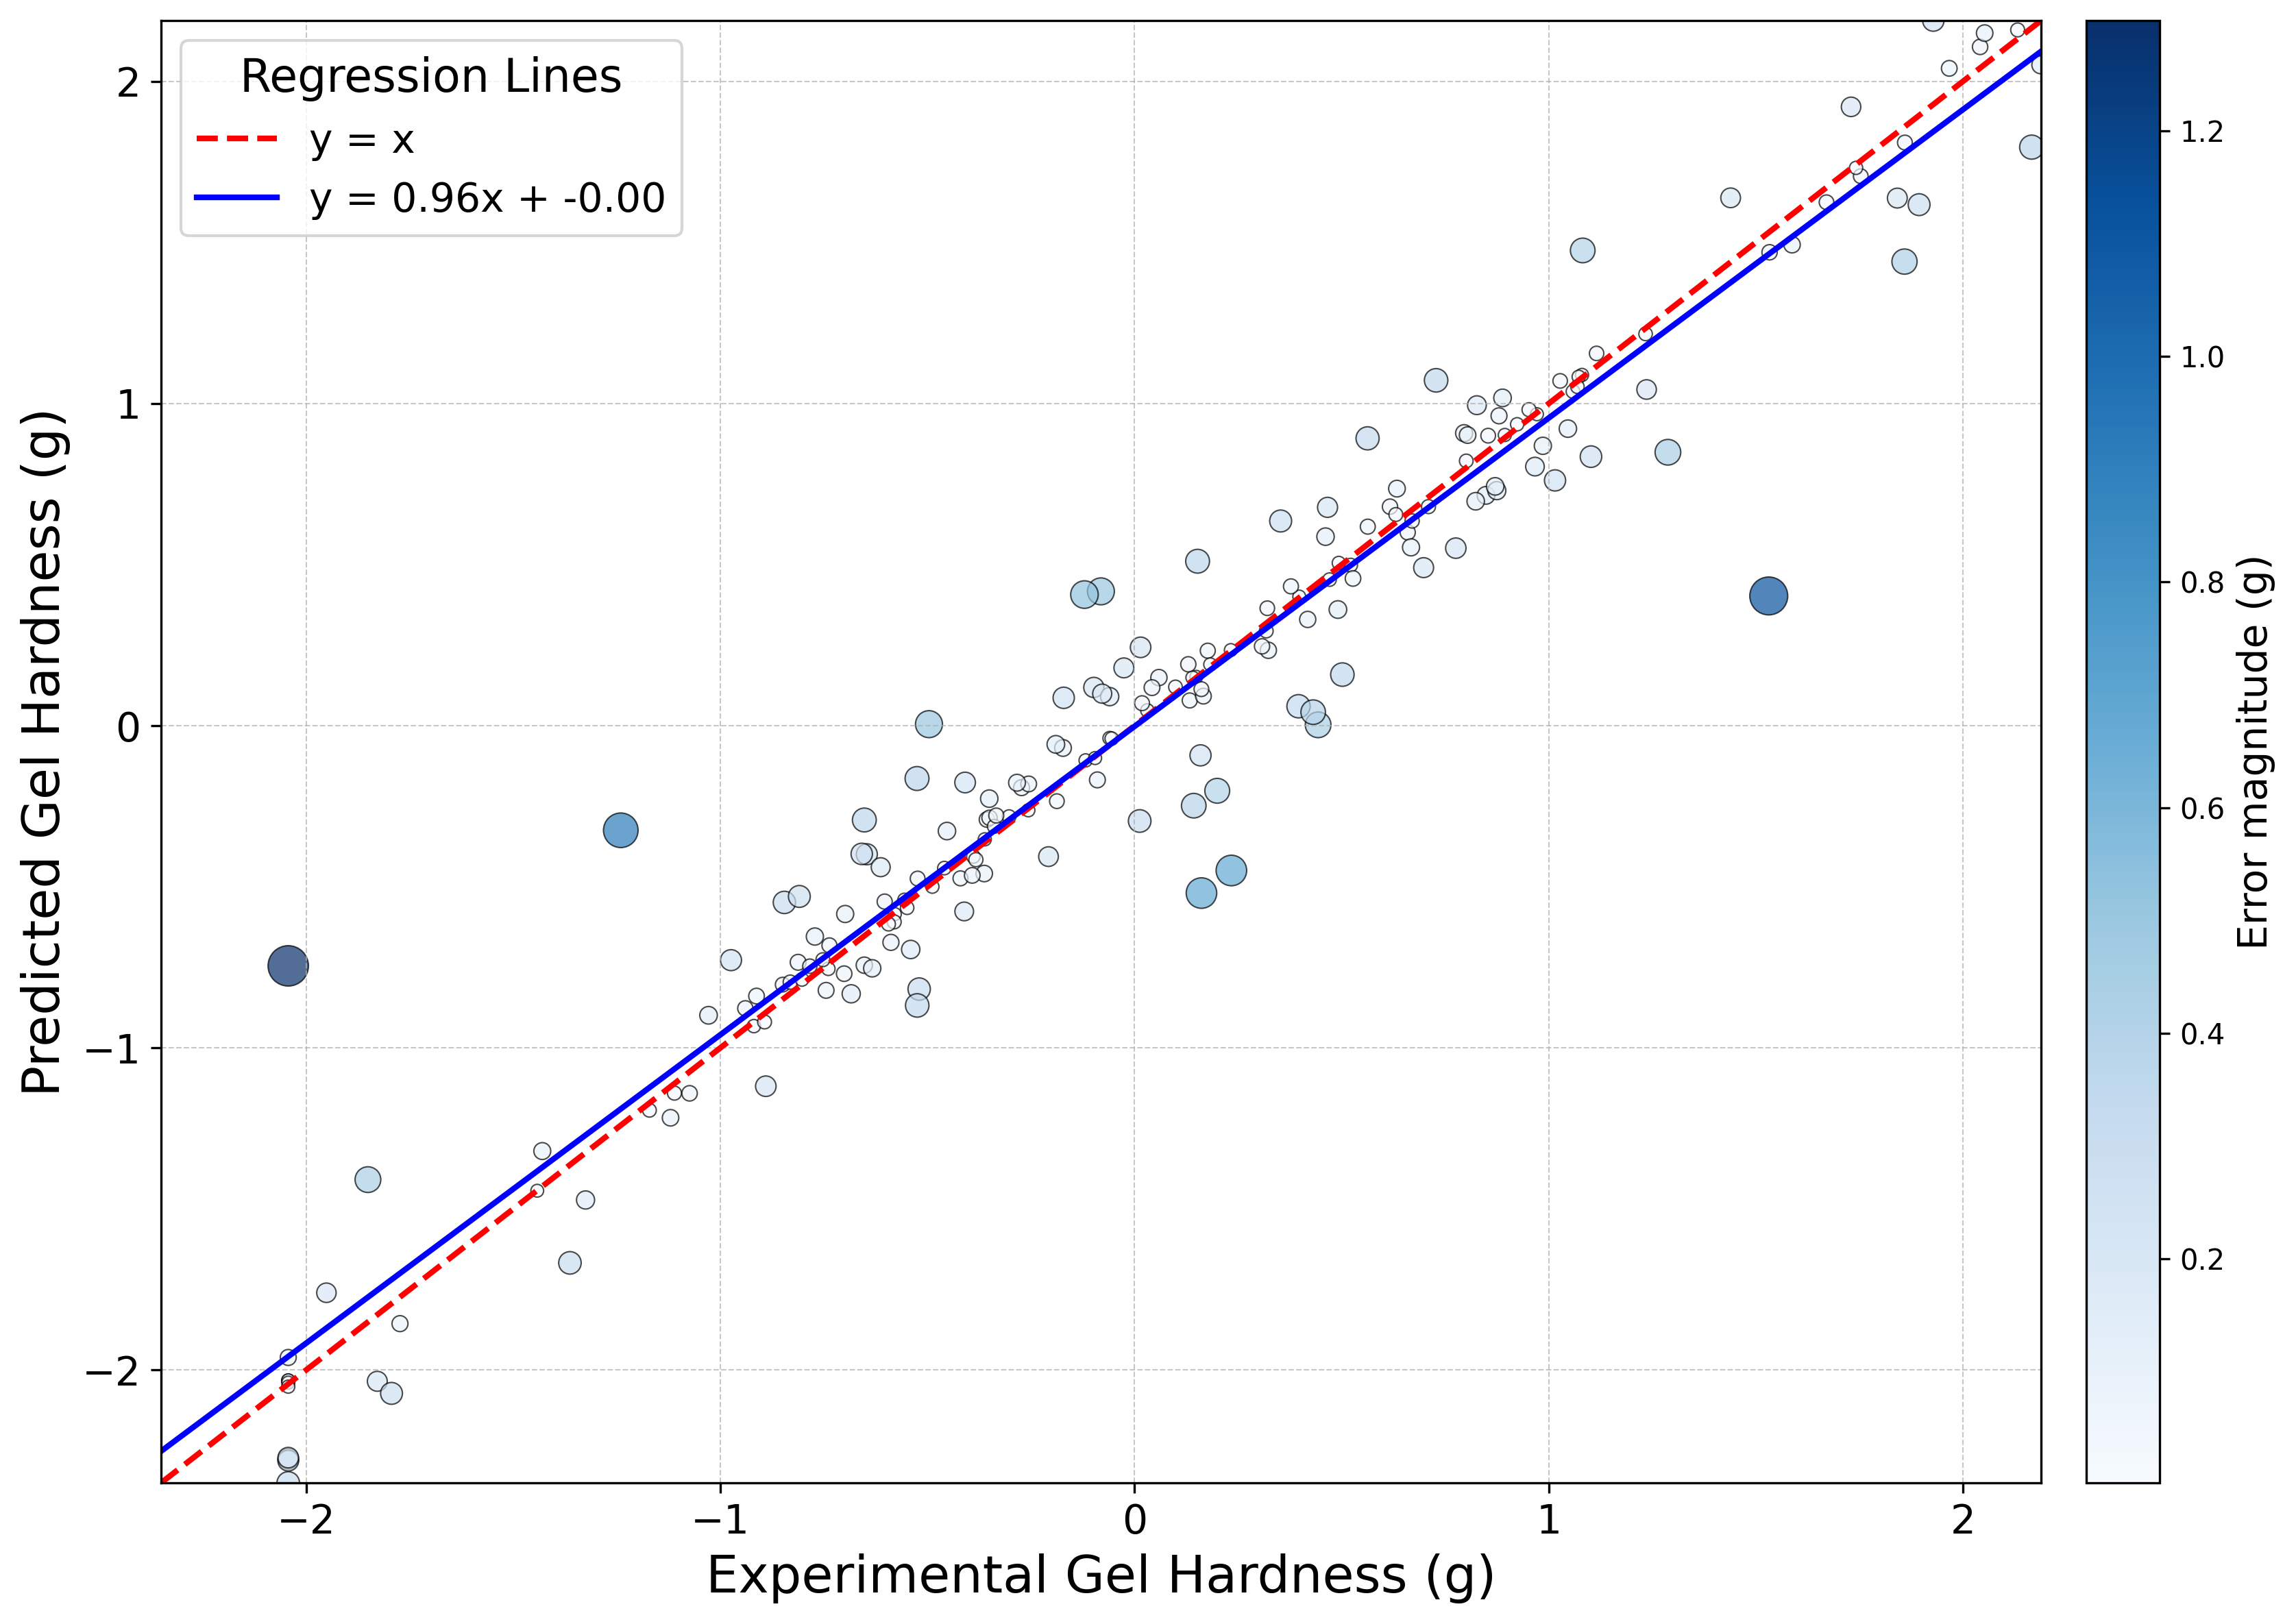

In [123]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédictions du modèle sur les données de test
y_pred = model.predict(X_test)

# Calcul des métriques de performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Affichage des métriques
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Tracer le graphique optimisé
plt.figure(figsize=(12, 8), dpi=300)

# Scatter plot avec la palette de bleus
scatter = sns.scatterplot(
    x=y_test,
    y=y_pred,
    hue=np.abs(y_test - y_pred),  # Erreur absolue en couleur
    palette='Blues',  # Nuances de bleu
    size=np.abs(y_test - y_pred),  # Taille en fonction de l'erreur
    sizes=(20, 200),  # Taille minimale et maximale
    alpha=0.7,  # Transparence pour éviter le chevauchement
    edgecolor='k',  # Bordure pour améliorer la lisibilité
    linewidth=0.5,
    legend=False  # Supprime l'échelle des couleurs de la légende
)

# Ligne idéale (y = x) en pointillés rouges
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label="y = x")

# Ajouter la régression linéaire (y = ax + b)
a, b = np.polyfit(y_test, y_pred, 1)  # Estimation des coefficients de la régression linéaire
y_reg = a * np.array([min_val, max_val]) + b  # Calcul des valeurs y pour la courbe
plt.plot([min_val, max_val], y_reg, color='blue', linestyle='-', linewidth=2, label=f"y = {a:.2f}x + {b:.2f}")

# Annoter l'erreur maximale (avec un fond blanc pour lisibilité)
'''max_error_index = np.argmax(np.abs(y_test - y_pred))
plt.annotate(
    f"Max Error: {y_test.iloc[max_error_index]} → {y_pred[max_error_index]:.2f}",
    (y_test.iloc[max_error_index], y_pred[max_error_index]),
    textcoords="offset points",
    xytext=(30, 30),  # Décalage pour éviter la superposition sur les points
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),  # Fond blanc
    arrowprops=dict(arrowstyle="->", color='black', lw=1.5)
)'''

# Ajustements des axes
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Ajouter le titre et les labels
plt.xlabel("Experimental Gel Hardness (g)", fontsize=18)
plt.ylabel("Predicted Gel Hardness (g)", fontsize=18)
#plt.title(f"Comparison of model predictions (R² = {r2:.4f})", fontsize=20)

# Ajuster la taille des ticks (graduations des axes)
plt.tick_params(axis='both', labelsize=14)

# Légende avec uniquement les deux droites (idéal + régression)
plt.legend(fontsize=14, title="Regression Lines", title_fontsize=16, loc='upper left')

# Ajouter une colorbar pour une meilleure lisibilité des erreurs
norm = plt.Normalize(np.abs(y_test - y_pred).min(), np.abs(y_test - y_pred).max())
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
cbar.set_label("Error magnitude (g)", fontsize=14)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Grille plus discrète
plt.tight_layout()
plt.show()


## CROSS VALIDATION ON 5-KFOLD

In [125]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Définir la validation croisée (5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Appliquer la validation croisée avec R² comme métrique
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')

# Afficher les résultats
print(f"Scores de chaque fold: {scores}")
print(f"R² moyen: {np.mean(scores):.4f}")
print(f"Écart-type des scores: {np.std(scores):.4f}")


Scores de chaque fold: [0.88783297 0.86215903 0.90094092 0.88993778 0.85775227]
R² moyen: 0.8797
Écart-type des scores: 0.0168


In [126]:
y_test.shape

(204,)

In [ ]:
import pandas as pd
import numpy as np

# 2. Inverser la transformation Box-Cox si besoin
y_test_original = pt.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
y_pred_original = pt.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# 3. Calcul de l’écart absolu
df_results = pd.DataFrame({
    'Valeur réelle (y)': y_test_original,
    'Prédiction (ŷ)': y_pred_original
})
df_results['Écart absolu'] = np.abs(df_results['Valeur réelle (y)'] - df_results['Prédiction (ŷ)'])

# 4. Tri du meilleur au moins bon
df_sorted = df_results.sort_values(by='Écart absolu', ascending=True)

# 5. Affichage
print(f"✅ {len(df_sorted)} prédictions classées de la meilleure à la moins bonne :\n")
display(df_sorted)



✅ 204 prédictions classées de la meilleure à la moins bonne :



,Valeur réelle (y),Prédiction (ŷ),Écart absolu
115,1.00,1.02,0.02
106,7.46,7.43,0.03
165,1.00,0.97,0.03
30,1.00,1.04,0.04
43,1.00,1.04,0.04
...,...,...,...
141,1949.48,1439.39,510.09
144,2022.00,2647.54,625.54
65,1877.25,1175.66,701.59
91,2587.13,1753.62,833.51


📁 Fichier 'resultats_predictions_tries.xlsx' enregistré avec succès.


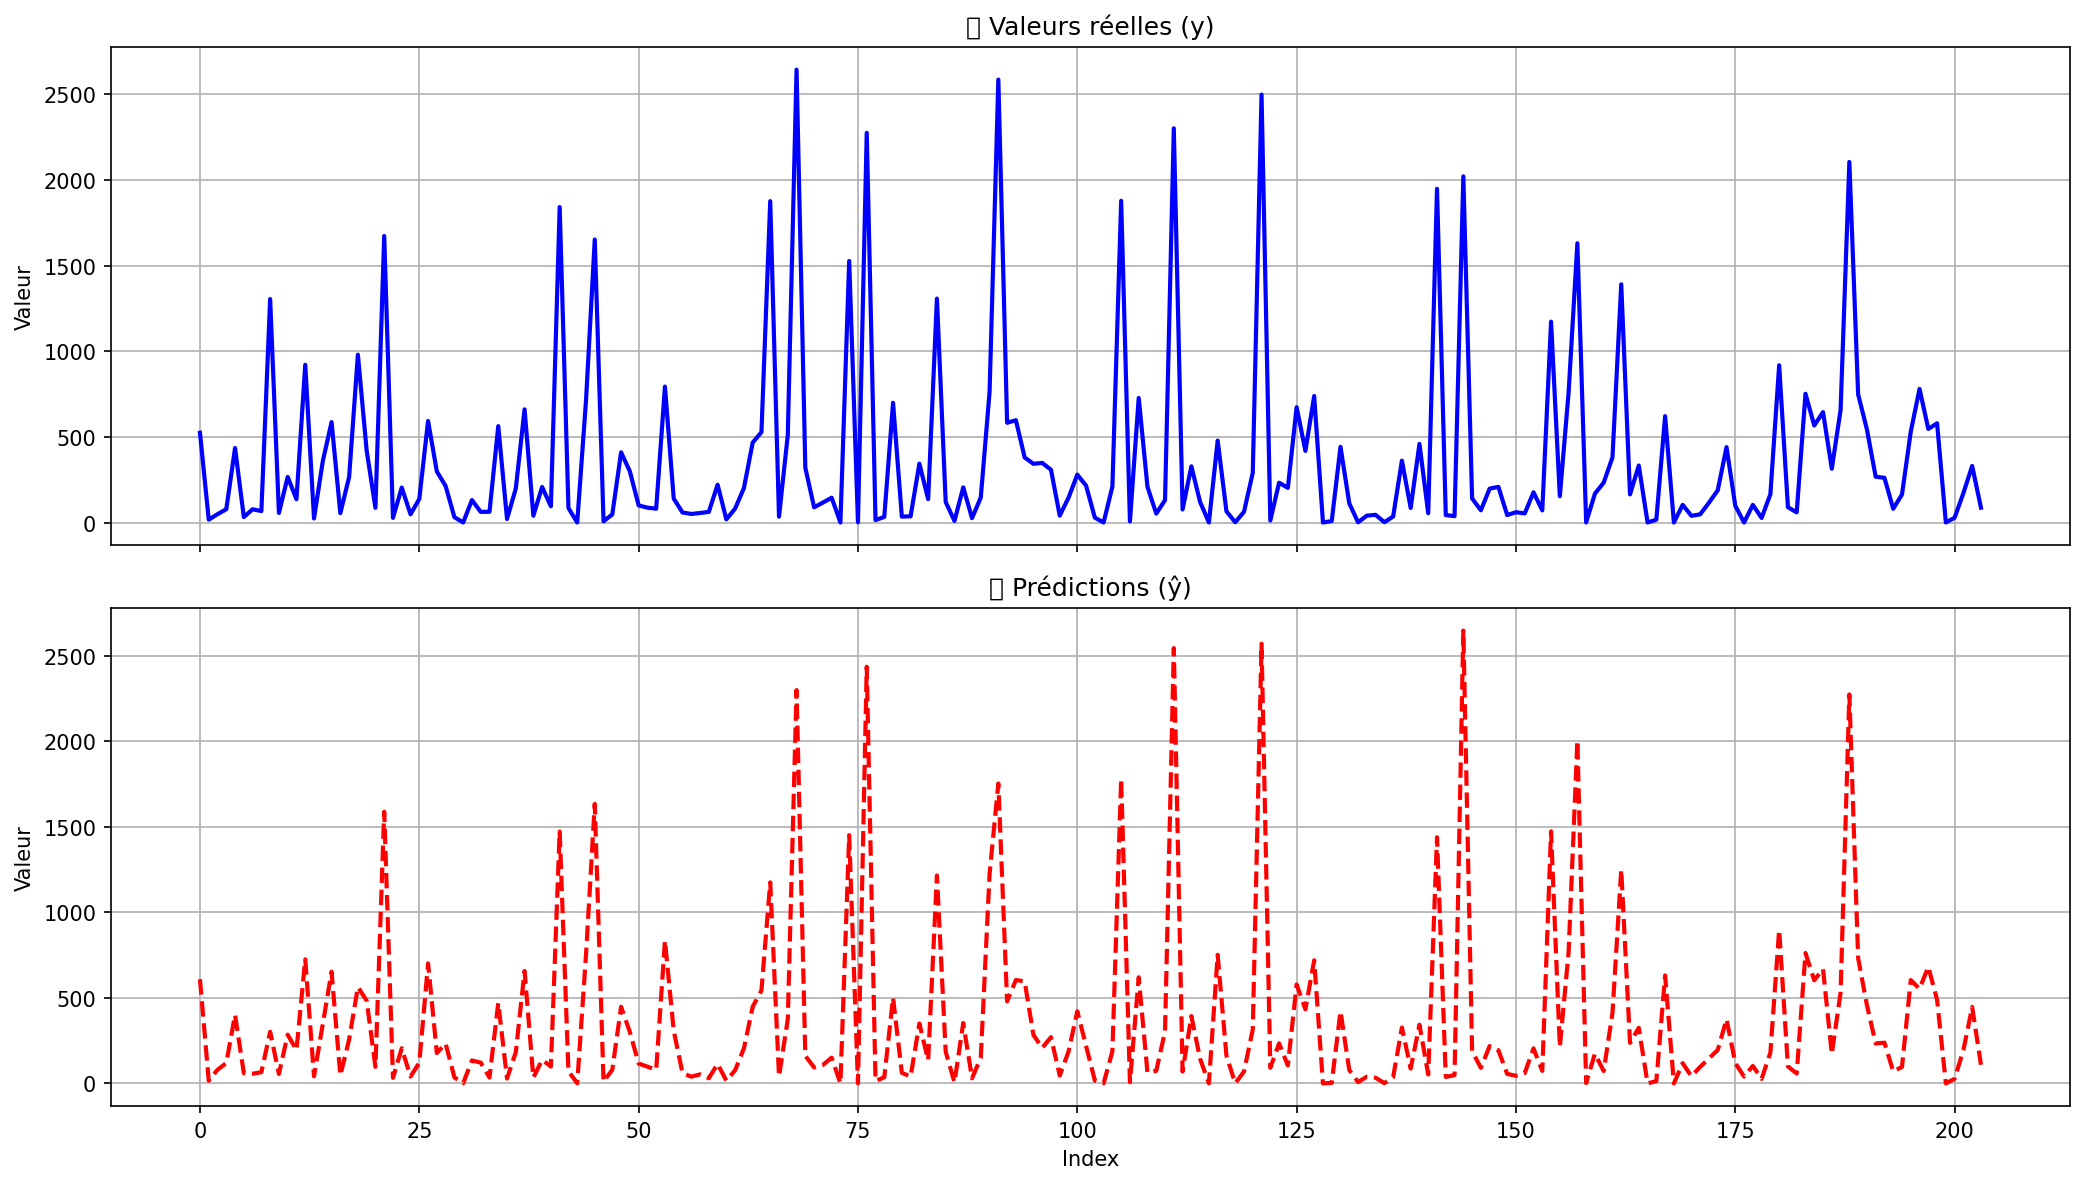

In [128]:
import matplotlib.pyplot as plt

# 8. Subplot comparatif : valeurs réelles vs prédictions (non superposées)
fig, axes = plt.subplots(2, 1, figsize=(14, 8), dpi=150, sharex=True)

# Graphe 1 : Valeurs réelles
axes[0].plot(y_test_original, color='blue', linewidth=2)
axes[0].set_title("✅ Valeurs réelles (y)")
axes[0].set_ylabel("Valeur")
axes[0].grid(True)

# Graphe 2 : Prédictions
axes[1].plot(y_pred_original, color='red', linewidth=2, linestyle='--')
axes[1].set_title("📊 Prédictions (ŷ)")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Valeur")
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Check the homoscedasticity of the residuals and the distribution of the residuals

✔ If the residuals (errors between prediction and true value) are randomly distributed around zero (without any obvious structure), this means that the homoscedasticity assumption is met.

❌ If a particular shape appears (e.g. open or closed cone), this indicates heteroscedasticity, which can distort predictions and require data transformation.

✔ If the residuals have a bell-shaped (Gaussian) distribution, then the normality hypothesis is respected.

❌ If the residuals are asymmetric or have extreme values ​​(thick tails), this may indicate the presence of outliers or the need for a data transformation (e.g. logarithmic).

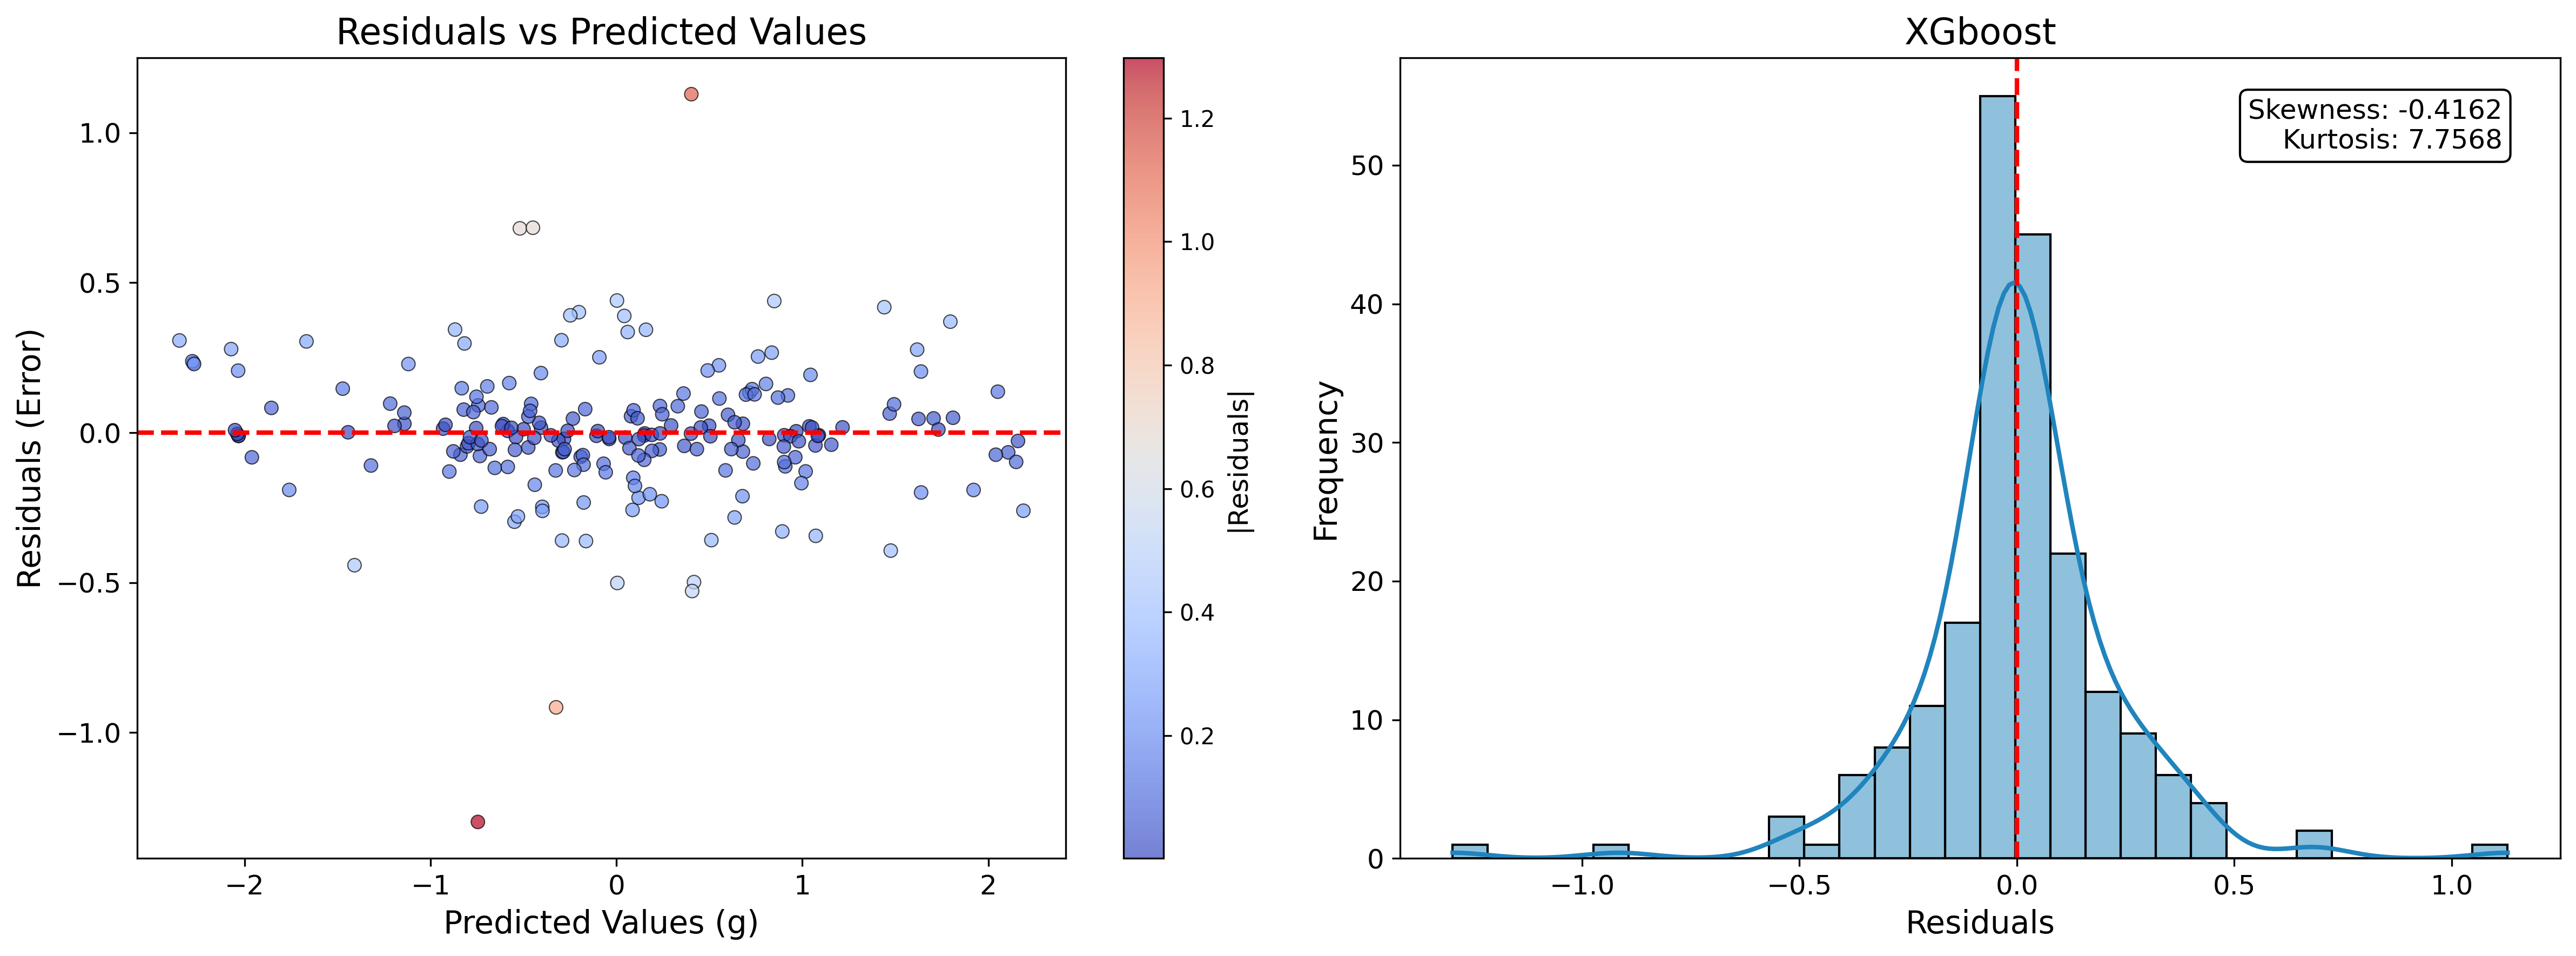

Skewness : -0.4162
Kurtosis : 7.7568


In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Calculation of residuals
residuals = y_test - y_pred

# Creating a single figure with 2 sub-graphs
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

# 1st Graph: Plot of residuals vs predicted values
scatter = axes[0].scatter(y_pred, residuals, c=np.abs(residuals), cmap="coolwarm", alpha=0.7, edgecolor="k", linewidth=0.5)
axes[0].axhline(y=0, color="red", linestyle="dashed", linewidth=2)  # Ligne horizontale à 0
axes[0].set_xlabel("Predicted Values (g)", fontsize=14)
axes[0].set_ylabel("Residuals (Error)", fontsize=14)
axes[0].set_title("Residuals vs Predicted Values", fontsize=16)
axes[0].tick_params(axis='both', labelsize=12)

# Adding a colorbar for better interpretation
cbar = fig.colorbar(scatter, ax=axes[0])
cbar.set_label("|Residuals|", fontsize=12)

# 2nd Graph: Histogram of residuals
sns.histplot(residuals, bins=30, kde=True, color="#2084bd", edgecolor="black", ax=axes[1], line_kws={'linewidth': 2})
axes[1].axvline(x=0, color='red', linestyle='dashed', linewidth=2)  # Ligne centrale
axes[1].set_title("XGboost", fontsize=16)
axes[1].set_xlabel("Residuals", fontsize=14)
axes[1].set_ylabel("Frequency", fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)

# Adding skewness and kurtosis as annotations
axes[1].annotate(f"Skewness: {stats.skew(residuals):.4f}\nKurtosis: {stats.kurtosis(residuals):.4f}", 
                 xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontsize=12, bbox=dict(boxstyle="round", fc="white", ec="black"))

# Display
plt.tight_layout()
plt.show()

print(f"Skewness : {stats.skew(residuals):.4f}")
print(f"Kurtosis : {stats.kurtosis(residuals):.4f}")


In [130]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

# Ajouter une constante aux variables explicatives
X = sm.add_constant(X_test)

# Exécuter le test de Breusch-Pagan
test = het_breuschpagan(residuals, X)
p_value = test[1]

# Affichage des résultats avec interprétation
print(f"Breusch-Pagan p-value: {p_value:.4f}")

if p_value < 0.05:
    print("🔴 Hétéroscédasticité détectée : La variance des résidus n'est pas constante.")
    print("📌 Il peut être nécessaire d'appliquer une transformation des données ou d'utiliser une régression robuste.")
else:
    print("🟢 Homoscédasticité confirmée : La variance des résidus est constante.")
    print("✅ Aucune correction nécessaire pour l’hétéroscédasticité.")


Breusch-Pagan p-value: 0.8976
🟢 Homoscédasticité confirmée : La variance des résidus est constante.
✅ Aucune correction nécessaire pour l’hétéroscédasticité.


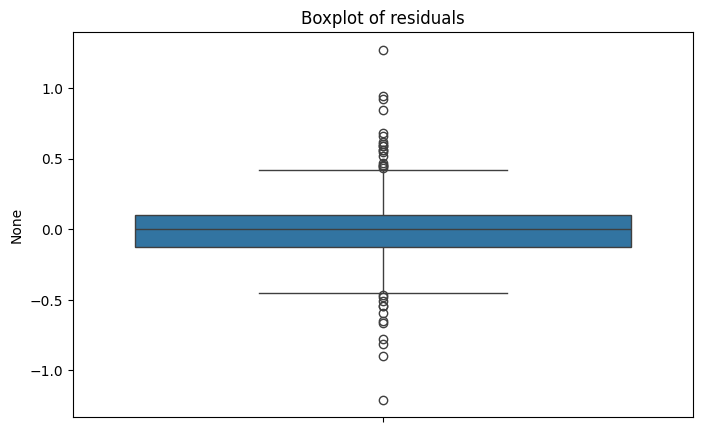

In [548]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(y=residuals)
plt.title("Boxplot of residuals")
plt.show()


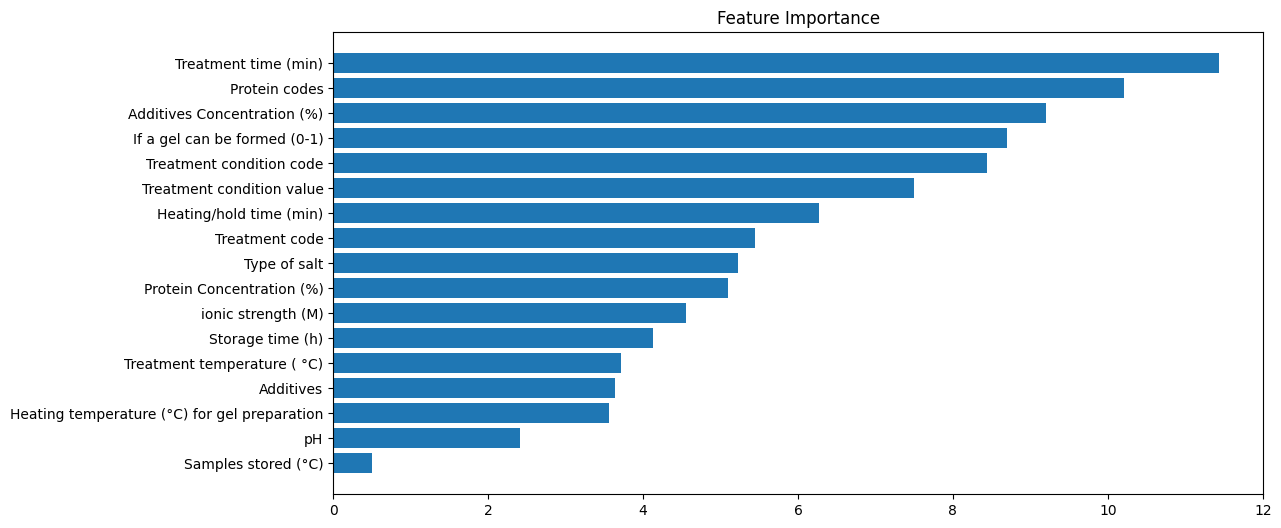

In [549]:
from matplotlib import pyplot as plt

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

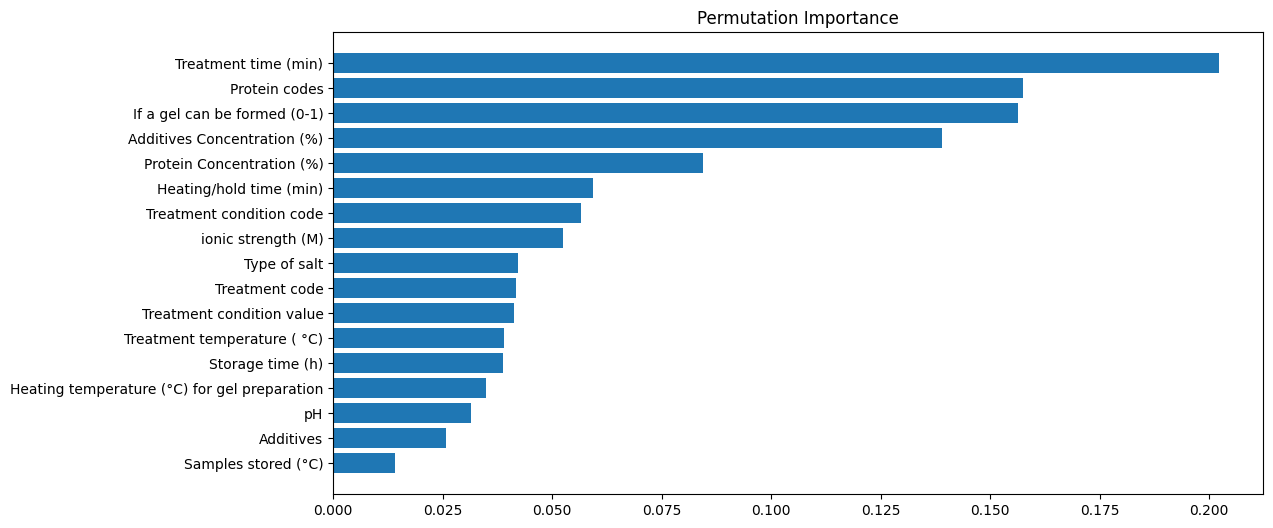

In [550]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')
plt.show()

### Explanation using SHAP values

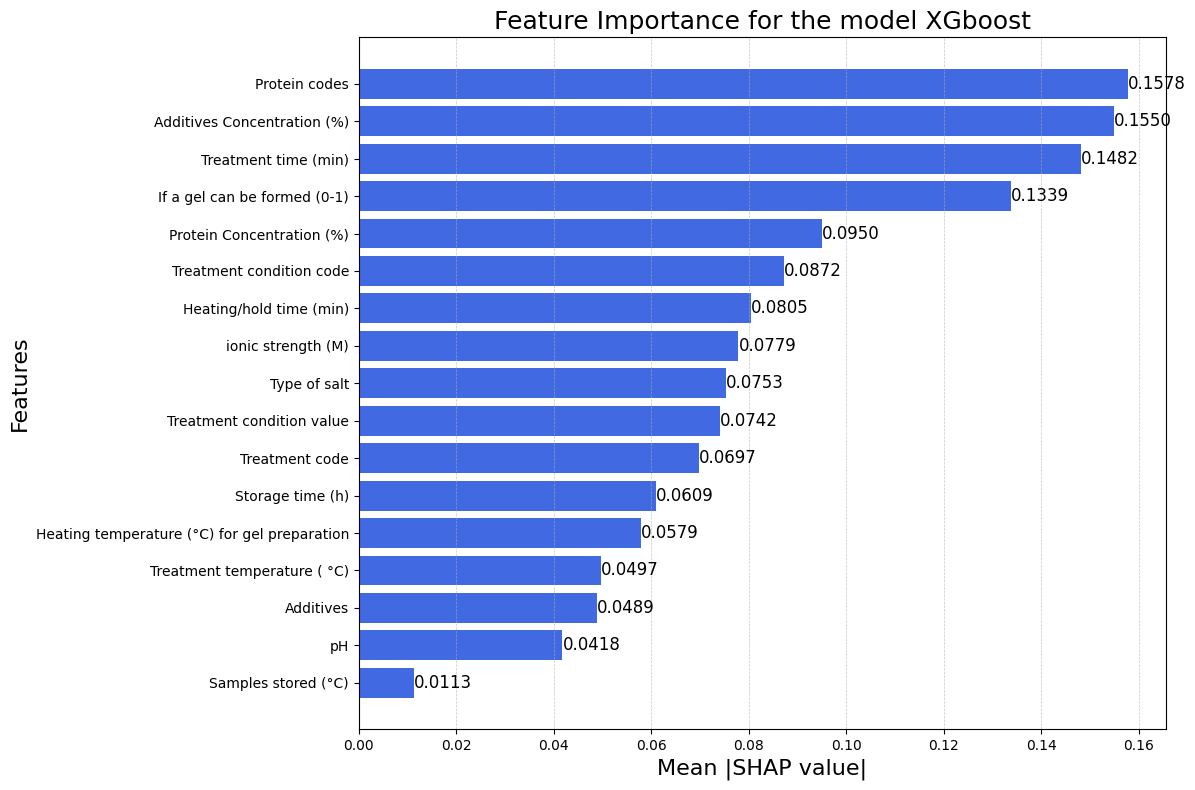

In [551]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Calcul des valeurs SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

# Extraire les valeurs moyennes SHAP par caractéristique
shap_means = np.abs(shap_values.values).mean(axis=0)

# Trier les caractéristiques par importance
sorted_indices = np.argsort(shap_means)[::-1]

# Définir le nombre de caractéristiques à afficher
max_display = min(X_test.shape[1], 20)

# Préparer les données triées
sorted_shap_means = shap_means[sorted_indices][:max_display]
sorted_features = X_test.columns[sorted_indices][:max_display]

# Création du graphique en barres
plt.figure(figsize=(12, 8))

bars = plt.barh(sorted_features[::-1], sorted_shap_means[::-1], color='royalblue')

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, sorted_shap_means[::-1]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.4f}',
             ha='left', va='center', fontsize=12, color='black')

plt.xlabel("Mean |SHAP value|", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.title("Feature Importance for the model XGboost", fontsize=18)
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

### Explanation for Technical Audience (Data Scientists):
This SHAP summary plot shows the average magnitude of SHAP values for features used in a **CatBoostRegressor model**. The SHAP value for each feature represents its contribution to the model's predictions. The features are ranked in descending order of importance based on their mean absolute SHAP values. 

- **"Ionic strength (M)"** has the highest importance, indicating it significantly impacts the model's predictions.
- Features like **"Samples stored (°C)"** and **"Type of salt"** also play crucial roles but are less influential compared to "Ionic strength."
- Features such as **"Additives"** and **"Protein codes"** have much smaller SHAP values, implying they contribute less to the prediction.

The results can guide feature engineering and domain understanding by highlighting which variables are driving the predictions.

---

### Explanation for Non-Technical Stakeholders:
This plot helps us understand which factors are most important for the predictions made by the model. Each bar represents how much a specific factor (like **"Ionic strength"** or **"Samples stored temperature"**) influences the model's outcomes on average.

- The top factor, **"Ionic strength"**, has the biggest influence, meaning it strongly affects how the predictions change.
- Factors like the **"storage temperature"** and the **"type of salt"** are also quite important, but less so than ionic strength.
- Factors lower down, like **"Additives"**, have very little impact on the model's predictions.

This information can help focus on the most critical factors for decision-making or further experimentation.

In [28]:
shap.initjs()
shap.plots.force(shap_values[0, ...])

In [30]:
shap.initjs()
shap.plots.force(shap_values[11, ...])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

### Using DiCE library for counterfactual explanations

In [40]:
import dice_ml
from dice_ml import Dice

d_gel = dice_ml.Data(dataframe=df_clean,
                      continuous_features=list(numerical_cols),
                      outcome_name='Hardness/firmness/strength (g)')

# We provide the type of model as a parameter (model_type)
catboost_with_preprocessing = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))])
catboost_with_preprocessing.fit(X_train, y_train)
m_gel = dice_ml.Model(model=catboost_with_preprocessing, backend="sklearn", model_type='regressor')
exp_genetic_gel = Dice(d_gel, m_gel, method="genetic")

In [32]:
import joblib
joblib.dump(Xg_boost_model, 'modelBoosting.joblib')

['modelBoosting.joblib']

In [33]:
import joblib
import numpy as np

# Charger le modèle
model = joblib.load(r"C:\Model_to_predict_GelHardness\Notebooks\modelBoosting.joblib")

# Exemple de données d'entrée
X_input = np.array([[
    50, 50.0, 5, 5, 50.0, 25, 5.0,
    1, 50.0, 7.0, 1, 0.5, 100, 60.0, 4,
    500, 0, 500.0
]])

# Prédiction
prediction = model.predict(X_input)

# Affichage du résultat
print(f"Prédiction du modèle : {prediction[0]:.2f}")


ValueError: Feature shape mismatch, expected: 17, got 18